# 0 Required imports, hyperparameters and general functions

## 0.1 Required imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
import glob
import time

## 0.2 Hyperparameters

In [2]:
# 1 Classifier parameters
# Features to be applied
hog_feat = True # HOG features on or off
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off

# Feature detection parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
hog_channel = "1" # Can be 0, 1, 2, or "ALL"



classifier_shape = (64,64) # Defines the image shape required for the classifier


window_ratio = 1.5 # window ratio * window hight = window width

## 0.3 Plotting functions

In [3]:
def load_image(image_path):
    """
    Loads an image from "image_path" and returns image
    """    
    return mpimg.imread(image_path)


def plot_and_save_image(img, cmap_img = None, heading = None, save = False, save_path = None):
    """
    Plots an image in this notebook and optionally saves it
    Input:
    img (np.array): Image to be plotted
    cmap (str): Cmap for plotting if required
    heading (str): Heading to be displayed above image
    save (bool): Indicates whether image should be saved or not
    save_path (str): Path to where the image should be saved
    """
    plt.imshow(img, cmap = cmap_img)
    plt.axis("off")
    if heading:
        plt.title("{}".format(heading))
    plt.show
    if save:
        plt.imsave(save_path,img)
    

    
def plot_and_save_n_images(imgs, cmaps, headings, save = False, save_path = None,
                          images_per_column = 1, images_per_line = 2, figw = 8, figh = 4):
    """
    Plots n images in this notebook and optionally saves the figure in one file
    Input:
    imgs (np.array): Image to be plotted
    cmap (str): Cmap for plotting if required
    heading (str): Heading to be displayed above image
    save (bool): Indicates whether image should be saved or not
    save_path (str): Path to where the image should be saved
    """
    
    fig, axes = plt.subplots(images_per_column,images_per_line,figsize = (figw,figh))
    for i, ax in enumerate(axes.flat):
        if i in range(len(imgs)):
            ax.imshow(imgs[i],cmap = cmaps[i])
            ax.axis("off")
            if headings[i]:
                ax.set_title("{}".format(headings[i]),fontsize = 15, fontweight='bold')
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.axis("off")
    if save:
        fig.savefig(save_path)
    plt.show()

# 1 Create detection classifier (Histogram of Oriented Gradients (HOG))

## 1.0 Helper functions for feature extraction

In [99]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, from_file = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        if from_file:
            # Read in each one by one
            image = mpimg.imread(file)
        else:
            image = file
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 1.1 Prepare classifier data

In [5]:
# Import pathes to vehicle and none-vehicle test images
imgs_vehicle = glob.glob('labeled_data/vehicles/*/*.png')
imgs_non_vehicle = glob.glob('labeled_data/non-vehicles/*/*.png')

# Shuffle pathes
imgs_vehicle = shuffle(imgs_vehicle,random_state = 100)
imgs_non_vehicle = shuffle(imgs_non_vehicle, random_state = 100)
print("Number of images with cars:\t{}\nNumber of images without cars:\t{}\nTotal number of images:\t{}".format(len(imgs_vehicle),len(imgs_non_vehicle),len(imgs_vehicle)+len(imgs_non_vehicle)))

Number of images with cars:	8792
Number of images without cars:	8968
Total number of images:	17760


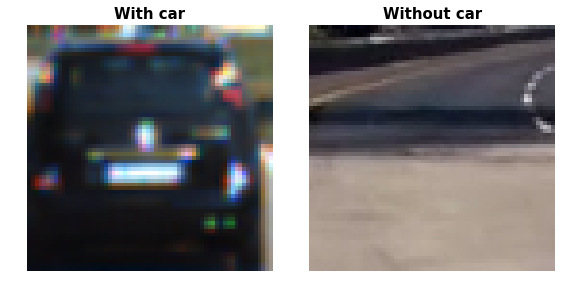

In [6]:
# Define example images
with_car = load_image(imgs_vehicle[0])
without_car = load_image(imgs_non_vehicle[0])
imgs = (with_car, without_car)
cmaps = (None,None)
headings = ("With car","Without car")
save_path = "output_images/01_classifier_images"

# Plot and save comparison of example images
plot_and_save_n_images(imgs, cmaps, headings, save = True, save_path = save_path, 
                       images_per_column = 1, images_per_line = 2, figw = 8, figh = 4)

## 1.2 Select features to be applied

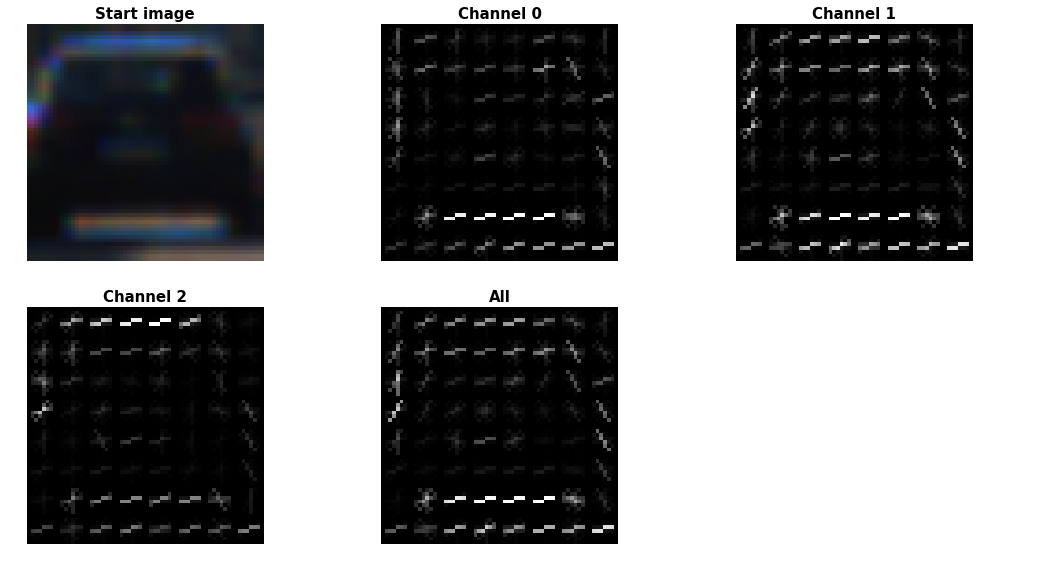

In [7]:
# Function to experiment with hog features
def visualize_hog(img, hog_channel):
    """
    Visualizes the hog_features based on the input image
    Input:
    img (np.array): Input image
    hog_channel: Indicates which hog_channels to be displayed (Can be 0, 1, 2, or "ALL")
    Output:
    imgs (list of np.arrays): List of visualized images
    cmaps (list of strings): Required cmaps for image display
    headings (list of strings): List of desired heading for each image
    """    

    vis = True
    feature_vec = True
            
    # Initialize lists to take up parameters for all images to be visualized (already contains initial image)
    imgs = [img]
    cmaps = [None]
    headings = ["Start image"]    
    
    # Add parameters for 0-image channel to lists
    if hog_channel == 0 or hog_channel == "ALL":
        imgs.append(img[:,:,0])
        cmaps.append("gray")
        headings.append("Channel 0")
    # Add parameters for 1-image channel to lists
    if hog_channel == 1 or hog_channel == "ALL":
        imgs.append(img[:,:,1])
        cmaps.append("gray")
        headings.append("Channel 1")
    # Add parameters for 2-image channel to lists
    if hog_channel == 2 or hog_channel == "ALL":
        imgs.append(img[:,:,2])
        cmaps.append("gray")
        headings.append("Channel 2")
    # Add parameters for all-image channels (black and white image) to lists
    if hog_channel == "ALL":
        imgs.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        cmaps.append("gray")
        headings.append("All")

    # Get image visualizations for all images in list
    for i, img_obj in enumerate(imgs[1:]):
        _, imgs[i+1] = get_hog_features(img_obj, orient, pix_per_cell, cell_per_block, 
                            vis=vis, feature_vec=feature_vec)
        
    return imgs, cmaps, headings

# Define example image
input_img = load_image(imgs_vehicle[100])

# Additional function to convert image to different color space (only required if not RGB image)
#input_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2YCrCb)

# Call hog_visualization function (see above)
imgs, cmaps, headings = visualize_hog(input_img,"ALL")

# Plot and save comparison of all visualized images
save_path = "output_images/02_hog_features_YCrCb"
plot_and_save_n_images(imgs, cmaps, headings, save = False, save_path = save_path, 
                       images_per_column = 2, images_per_line = 3, figw = 15, figh = 8)

Result: Empirical testing suggests best accuracy with minimum calculation time for RGB channel 1 (accuracy of classifier 0.949 vs accuracy for all color channels of 0.960; however only ~1/3 of calculation time

 ## 1.3 Create and preprocess feature vectors

In [8]:
import pickle

try:
    # Try to import features and labels from pickle file (if preprocessed earlier)    
    with open("y_labels.p","rb") as y_labels:
        y = pickle.load(y_labels)
        
    with open("X_features.p","rb") as X_features:
        X = pickle.load(X_features)
        
    print("Features and labels were loaded from pickle files")



except:
    # Generate label vector for vehicle and non-vehicle
    vehicle_label = np.ones(len(imgs_vehicle))
    non_vehicle_label = np.zeros(len(imgs_non_vehicle))

    # Concatenate label vectors
    y = np.concatenate((vehicle_label,non_vehicle_label))



    # Generate feature vector

    t1 = time.time()
    # Extract feature vectors for both vehicle and non-vehicle images
    vehicle_features = extract_features(imgs_vehicle, color_space = color_space, spatial_size = spatial_size,
                                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    non_vehicle_features = extract_features(imgs_non_vehicle, color_space = color_space, spatial_size = spatial_size,
                                            hist_bins=hist_bins, orient=orient,
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Seconds to extract hog features: {:.2f}".format(t2-t1))

    # Create an array stack of feature vectors
    X = np.concatenate((vehicle_features, non_vehicle_features),axis = 0).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    X = X_scaler.transform(X)

    # Dump variables in pickle files
    with open("X_features.p","wb") as X_features:
        pickle.dump(X, X_features)

    with open("y_labels.p","wb") as y_labels:
        pickle.dump(y,y_labels)
        
print("Shape of feature array:\t{}\nShape of label array:\t{}".format(X.shape,y.shape))

Features and labels were loaded from pickle files
Shape of feature array:	(17760, 3600)
Shape of label array:	(17760,)


In [9]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

## 1.4 Chose and train classifier (SVM)

In [10]:
try:
    # Try to load classifier from pickle (if fitted earlier)
    with open("classifier.p","rb") as cls:
        svc = pickle.load(cls)
    print("Classifier were loaded from pickel file.")

except:

    # Define SVM classifier
    svc = LinearSVC()

    # Fit classifier
    t1 = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print("Seconds to train classifier:\t{:.2f}".format(t2-t1))
    
    # Dump classifier in pickle file
    with open("classifier.p","wb") as cls:
        pickle.dump(svc,cls)

Classifier were loaded from pickel file.


In [11]:
# Evaluate classifier
accuracy = svc.score(X_test, y_test)
print("Accuracy of current classifier:\t{:.4f}".format(accuracy))

Accuracy of current classifier:	0.9854


[ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.
  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.
  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.
  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  1.
  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.  1.  1.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.
  1.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1

TypeError: Invalid dimensions for image data

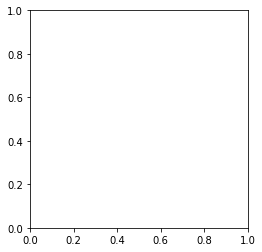

In [212]:
test_number = 1
print(svc.predict(X_test[0:300]))
print(X_test.shape)
plt.imshow(X_test[test_number])

# 2 Sliding Window Search

To be implemented:
- Only search through bottom half of the image
- Perform min, max and intermediate scale search
- Perform narrow window search close to the horizon and large window search close to the car

## 2.1 Define windows

In [72]:
# Read in test images

# Get all test image names
test_img_names = sorted(glob.glob('test_images/*.jpg'))

# Load test images into np.array
test_imgs = np.array([mpimg.imread(name) for name in test_img_names])
    
print("Shape of test image array:\n{}".format(test_imgs.shape))

Shape of test image array:
(6, 720, 1280, 3)


In [73]:
# HYPERPARAMETERS
y_start = 390
y_stop = 610
input_image_shape_x = 1280
y_window_gap = 20 # Pixel gap between windows in y direction
x_num_windows = 20 # Number of frames which will be distributed along the x-axis on one y level

y_window_h_min = 30 # Number of pixels for the minimum window hight of the top frame (must not be larger than 2* 
                    # y_window_gap)

In [74]:
def plot_and_save_test_imgs(img, y_start,y_stop, rectangle = False, point_1 = None, point_2 = None, 
                            img_save = False, save_path = None):
    """
    Enables display, adding of rectangled windows and saving of test images
    
    Input:
    img (np.array): Test image to be plotted, (rectangled and saved). E.g. 'test_imgs[0]'
    y_start (int): Starting pixel value of the new image in input image terms
    y_stop (int): Ending pixel value of the new image in input image terms
    rectangle (bool): Indicates, whether rectangle should be displayed on image
    point_1 (tuple): First corner point for the rectangle
    point_2 (tuple): Second corner point for the rectangle
    img_save (bool): Indicates, whether image should be saved
    save_path (str): Path for saving
    """
    img_plt = np.copy(img[y_start:y_stop,:,:])
    if rectangle:
        cv2.rectangle(img_plt, point_1, point_2,(0,0,255),6)
    plt.imshow(img_plt)
    plt.axis("off")
    if img_save:
        plt.imsave(save_path,img_plt)

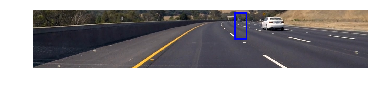

In [174]:
# Test plot_and_save_test_imgs() function and print outputs
plot_and_save_test_imgs(test_imgs[2], y_start,y_stop, rectangle = True, 
                        point_1 = (770, 10), point_2 = (815,110),img_save = True, save_path = "test.png")

In [175]:
def generate_window_pos_y(y_start, y_stop, y_window_gap):
    """
    Defines number of window layers in y-direction and determines window positions in y-direction 
    according to the new image size
    Input:
    y_start (int): Starting pixel value of the new image in input image terms
    y_stop (int): Ending pixel value of the new image in input image terms
    y_window_gap (int): Desired gap between two window layers in y-direction
    Output:
    num_window_layers_y (int): Number of window layers in y-direction
    window_positions_y (list): Window positions in y-direction
    """
    
    
    if y_window_gap < y_window_h_min:
        num_window_layers_y = (y_stop-y_start)//y_window_gap-1
    else:
        num_window_layers_y = (y_stop-y_start)//y_window_gap
    first_position_y = y_stop-y_start   
    window_positions_y = [first_position_y - i * y_window_gap for i in range(num_window_layers_y)]
    
    return num_window_layers_y, window_positions_y

In [176]:
# Test generate_window_pos_y() function and print outputs
num_window_layers_y, window_positions_y = generate_window_pos_y(y_start, y_stop, y_window_gap)
print("Number of layers in y-direction:\n{}".format(num_window_layers_y))
print("Window positions in y-direction:\n{}".format(window_positions_y))

Number of layers in y-direction:
10
Window positions in y-direction:
[220, 200, 180, 160, 140, 120, 100, 80, 60, 40]


#### To include in report:

Looking at the images I realized that all cars no matter how far they were away ended on one y-level.

In [177]:
def generate_window_sizes(num_window_layers_y,window_positions_y,y_window_h_min):
    """
    Determines the window sizes in x- and y-direction on each y-layer
    Input:
    num_window_layers_y (int): Number of window layers in y-direction
    window_positions_y (list): Window positions in y-direction
    y_window_h_min (int): Number of pixels for the minimum window hight of the top frame 
                            (must not be larger than 2*y_window_gap)
    Output:
    window_sizes (list of tuples): First value in each tuple represents size in x-direction in pixel, 
                                    second value represents size in y-direction in pixel
    window_sizes_x (list of int): List of window sizes in x-direction
    window_sizes_y (list of int): List of window sizes in y-direction    
    """
    
    # Define y-value of top-line for all windows
    window_top_all = window_positions_y[-1] - y_window_h_min
    
    # Define window sizes in y-direction
    window_sizes_y = [window_positions_y[i] - window_top_all for i in range(num_window_layers_y)]

    # Define window sizes in x-direction
    window_sizes_x = [int(window_sizes_y[i] * window_ratio) for i in range(num_window_layers_y)]

    # Concatenate x- and y-direction size of windows in one list of tuples
    window_sizes = [(window_sizes_x[i],window_sizes_y[i]) for i in range(len(window_sizes_x))]

    return window_sizes, window_sizes_x, window_sizes_y

In [178]:
# Test generate_window_sizes() function and print outputs
window_sizes,_,_ = generate_window_sizes(num_window_layers_y,window_positions_y,y_window_h_min)
print("Window sizes:\n{}".format(window_sizes))

Window sizes:
[(315, 210), (285, 190), (255, 170), (225, 150), (195, 130), (165, 110), (135, 90), (105, 70), (75, 50), (45, 30)]


In [179]:
def define_search_area_x(input_image_shape_x):
    """
    Defines variable search area in x-direction based on y-level (hardcoded assumtion: above 110 y-pixel = 
    full image width, at 40 y-pixel = half of the image width, between 40 and 110 y-pixel = linear interpolation)
    Input:
    input_image_shape_x (int): Image width in pixel
    search_area_x (list of tuple): List of tuple for search area in x-direction based on respective y-levels.
                                    First value = left start of search area,
                                    Second value = right start of search area    
    """

    # Define search area for bottom half of image
    search_area_x_bottom = [(0,input_image_shape_x) for i in range(5)]

    # Define search area for the top line of the image
    search_area_x_uppest = (int(input_image_shape_x/2-input_image_shape_x/4),int(input_image_shape_x/2+
                                                                            input_image_shape_x/4))

    # Define search area for the upper half of image
    factor_left = (search_area_x_uppest[0]-0)/5
    factor_right = (input_image_shape_x-search_area_x_uppest[1])/4
    search_area_x_top = [(int(factor_left*i),int(input_image_shape_x-(factor_right*i))) for i in range(5)]

    # Concatenate bottom and upper half search areas in x-direction based on y-level
    search_area_x = search_area_x_bottom + search_area_x_top
    
    return search_area_x

In [180]:
# Test define_search_area_x()) function and print outputs
search_area_x = define_search_area_x(input_image_shape_x)
print(search_area_x)

[(0, 1280), (0, 1280), (0, 1280), (0, 1280), (0, 1280), (0, 1280), (64, 1200), (128, 1120), (192, 1040), (256, 960)]


In [181]:
def def_window_positions(window_positions_y, window_sizes, search_area_x):
    """
    Define window positions (x- and y-values)
    Input:
    window_positions_y (list): Window positions in y-direction
    window_sizes (list of tuples): First value in each tuple represents size in x-direction in pixel, 
                                    second value represents size in y-direction in pixel
    search_area_x (list of tuple): List of tuple for search area in x-direction based on respective y-levels.
                                    First value = left start of search area,
                                    Second value = right start of search area
    Output:
    window_positions (list of tuple of tuples): Returns a list of tuples with one tuple for each window. Each
                                                tuple contains two tuples representing the two points required
                                                to define the window.
    """

    window_positions = []

    for i,pos_y in enumerate(window_positions_y):
        x_size_tmp = search_area_x[i][1] - search_area_x[i][0]
        window_slide = (x_size_tmp-window_sizes[i][0])//(x_num_windows-1)
        lb_y = pos_y
        rt_y = pos_y - window_sizes[i][1]
        for j in range(x_num_windows):
            lb_x = int(search_area_x[i][0] + j * window_slide)
            rt_x = int(search_area_x[i][0] + window_sizes[i][0] + j * window_slide)
            window_positions.append(((lb_x,lb_y),(rt_x,rt_y)))
    return window_positions

((0, 220), (315, 10))


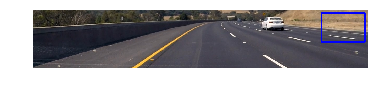

In [182]:
# Test indow_positions() function and print example output
window_positions = def_window_positions(window_positions_y, window_sizes, search_area_x)        
print(window_positions[0])

plot_and_save_test_imgs(test_imgs[2], y_start, y_stop, rectangle = True, 
                        point_1 = window_positions[119][0], point_2 = window_positions[119][1],
                        img_save = True, save_path = "test2.png")

## 2.2 Get features for windows

In [183]:
def assemble_and_resize_windows(img, window_positions, y_start = y_start, y_stop = y_stop,
                                classifier_shape = classifier_shape):
    img = img[y_start:y_stop,:,:]
    window_imgs = []
        
    for position in window_positions:
        tmp_img = img[position[1][1]:position[0][1],position[0][0]:position[1][0],:]
        tmp_img = cv2.resize(tmp_img,dsize=classifier_shape)
        window_imgs.append(tmp_img)
        
        
    return np.array(window_imgs)

In [184]:
window_imgs = assemble_and_resize_windows(test_imgs[2], window_positions=window_positions)

print(window_imgs.shape)

(200, 64, 64, 3)


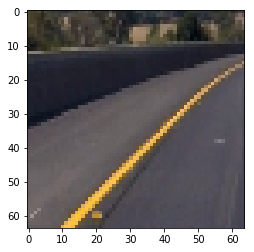

In [185]:
example = window_imgs[27]

plt.imshow(example)
#svc.predict(example)

In [204]:
def get_window_features(imgs, color_space = color_space, spatial_size = spatial_size,
                 hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):
    window_features = extract_features(imgs,color_space,spatial_size,hist_bins,orient,pix_per_cell,
                                       cell_per_block, hog_channel,spatial_feat,hist_feat,hog_feat,
                                       from_file = False)
    
    window_features = np.array(window_features).astype(np.float64)
    
    # Fit a per-column scaler
    window_scaler = StandardScaler().fit(window_features)

    # Apply the scaler to X
    windows_scaled = window_scaler.transform(window_features)
    
    return windows_scaled

In [205]:
windows_scaled = get_window_features(window_imgs)

/home/wolfgang/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [206]:
def make_prediction(windows_scaled):
    prediction = svc.predict(windows_scaled)
    return prediction

In [207]:
x=make_prediction(windows_scaled)
print(x)

[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.
  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.
  1.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  1.  0.  1.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  1.  0.  0.
  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.
  0.  1.]


1.0


(-0.5, 63.5, 63.5, -0.5)

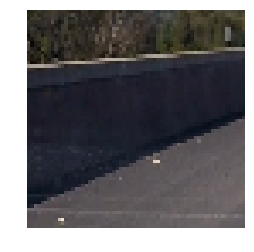

In [208]:
num = 1
example = window_imgs[num]
print(x[num])
#feature_test = get_window_features(example)

plt.imshow(example)
plt.axis("off")
#svc.predict(feature_test)

In [ ]:
    vehicle_features = extract_features(imgs_vehicle, color_space = color_space, spatial_size = spatial_size,
                                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, hog_channel=hog_channel,
                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    non_vehicle_features = extract_features(imgs_non_vehicle, color_space = color_space, spatial_size = spatial_size,
                                            hist_bins=hist_bins, orient=orient,
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print("Seconds to extract hog features: {:.2f}".format(t2-t1))

    # Create an array stack of feature vectors
    X = np.concatenate((vehicle_features, non_vehicle_features),axis = 0).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    X = X_scaler.transform(X)

In [43]:
def resize_and_extract_img_feat(img, classifier_shape = classifier_shape ,hog_channel = hog_channel, orient = orient, pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block, vis=False, feature_vec=True):
    """
    Resizes single image of any size and extracts the hog-features
    
    Output:
    Image features ready for classifier predicition
    """
    
    # Resize image
    img = cv2.resize(img,dsize=classifier_shape)
    
    # Isolate color channel
    img = img[:,:,hog_channel]

    # Generate color features
    img_features = get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)
    
    return img_features, img

In [46]:
# Build all features for windows of an image
def get_img_features(img, window_positions, y_start, y_stop):
    img = img[y_start:y_stop,:,:]
    window_features = []
    
    # To be removed
    window_imgs = []
    
    for position in window_positions:
        tmp_img = img[position[1][1]:position[0][1],position[0][0]:position[1][0],:]
        
        # To be removed when img is removed
        img_features, tmp_img = resize_and_extract_img_feat(tmp_img)
        window_imgs.append(tmp_img)
        
        
        window_features.append(img_features)
    
    # To be removed
    window_imgs = np.array(window_imgs)
    
    window_features = np.array(window_features)
    return window_features, window_imgs

In [47]:
window_features, window_imgs = get_img_features(test_imgs[0], window_positions,y_start=y_start, y_stop=y_stop)
print(window_features.shape)
print(window_imgs.shape)

/home/wolfgang/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(200, 3600)
(200, 64, 64)


## 2.3 Fit images and make prediction

In [35]:
def fit_scaler_and_classify(window_features):
    # Fit a per-column scaler
    #X_scaler = StandardScaler().fit(window_features)

    # Apply the scaler to X
    #scaled = X_scaler.transform(window_features)
    
    prediction = svc.predict(window_features)
    return prediction

In [36]:
prediction = fit_scaler_and_classify(window_features)
print(prediction[:])

[ 1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


In [31]:
def draw_windows_on_image(img, window_positions, prediction,y_start,y_stop, img_save = False, save_path = None):
    img_plt = img[y_start:y_stop,:,:]
    for position, pred in zip(window_positions,prediction):
        if pred:
            cv2.rectangle(img_plt, position[0], position[1],(0,0,255),6)
    plt.imshow(img_plt)
    plt.axis("off")
    if img_save:
        plt.imsave(save_path,img_plt)

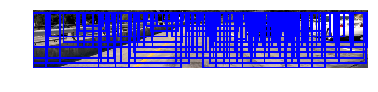

In [32]:
draw_windows_on_image(test_imgs[0], window_positions,prediction, y_start=y_start, y_stop=y_stop, 
                      img_save = True, save_path = "test3.png")   

In [ ]:
try_img = draw_on
try_img = try_img[10:120,120:285,:]
print(try_img.shape)

try_img = resize_and_extract_img_feat(try_img)


#plt.imshow(try_img)
svc.predict(try_img)

In [ ]:
# Extract windows from image


for window in window_positions:
    

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions based on only
# 1 color channel
color_channel = 1
y_start = 340
y_stop = 660




# If res

def identify_cars_1c(img,color_channel, y_start, y_stop, orient, pix_per_cell, cell_per_block):
    """    
    Input:
    img (np.array): 3-channel image to be screened for cars. If image needs to transferred to another 
                    color channel or should be rescaled this needs to be performed before handover to 
                    this function
    color_channel (int): Number from 0 to 2 to indicate color channel to be selected
    y_start (int): Starting pixel value for search in image in y-direction
    y_stop (int): Ending pixel value for search in image in y-direction
    orient, pix_per_cell, cell_per_block: Hog image hyperparameters as defined in beginning of this notebook
    
    """
    # Create image copy with 3 color channels to write on
    draw_img = np.copy(img)    
    
    # Isolate selected color channel
    img = img[:,:,color_channel]
    
    # Normalize image
    img = img.astype(np.float32)/255
    
    """
    # Create image search area
    img_tosearch = img[y_start:y_stop,:]
    
    # Define overall hog for the image
    hog = get_hog_features(img_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    """
    
    # Create image search areas
    
    
    
    
    
    
    
    
    # Create image search areas between 
    
    
    
    

In [ ]:
#Now lets explore a more efficient method for doing the sliding window approach, 
# one that allows us to only have to extract the Hog features once. 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions 
def find_cars(img, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[y_start:y_stop,:,:]
    # One of next two lines required, depending wheter color channel is RGB or another one
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start),(xbox_left+win_draw,ytop_draw+win_draw+y_start),(0,0,255),6) 
                
    return draw_img
    
y_start = 400
y_stop = 656
scale = 1.5
    
out_img = find_cars(img, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [ ]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

# 3 Video Implementation

## 3.1 Define class to hold values of previous detections

## 3.2 Define function for identifying and filetring false positives

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## 3.3 Define function for overlapping bounding boxes

## 3.4 Apply pipeline on video stream